##GAN&CLIP&GA - WITH CALLBACKS

See how the model is training...


Authors: Maciej Domagała, Adam Komorowski

### GENERATING IMAGES

In [1]:
#@title Initialization (Installation, Imports) - check github branch!
%%capture
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt #imagenet_classes

!git clone https://github.com/maciejdomagala/clip_gans.git
%cd clip_gans
!git checkout evaluation ### WARNING!!!

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard

# IMPORTS
import warnings

import argparse
import os
import torch
import numpy as np
import pickle
import math
from tqdm import tqdm_notebook
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request
import cv2

from config import get_config
from problem import GenerationProblem
from operators import get_operators


warnings.filterwarnings('ignore')

In [3]:
#@title Input Parameters
target = "dog in the fog" #@param {type:"string"}
config = "DeepMindBigGAN256" #@param ["DeepMindBigGAN256", "DeepMindBigGAN512", "StyleGAN2_ffhq_nod", "StyleGAN2_car_nod", "StyleGAN2_church_nod"]
generations = 50 #@param {type:"number"}
callbacks_each = 25 #@param {type: "number"}
population_size = 64 #@param {type:"number"}
#number_of_loops =  1#@param {type:"number"}
algorithm_param = 'ga' #@param ['ga', 'de']

In [4]:
#@title Config 
config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    tmp_folder="./results"
)
vars(config).update(get_config(config.config))
config.pop_size = population_size
config.algorithm = algorithm_param
config.generations = generations
config.callbacks_each = callbacks_each

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)
if not os.path.exists(f'{config.tmp_folder}/{config.target}'): os.mkdir(f'{config.tmp_folder}/{config.target}')


In [11]:
#@title Support methods

def save_callback(algorithm):
    global config, iteration, loop, target

    iteration += 1

    sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
    X = np.stack([p.X for p in sortedpop])      
    ls = config.latent(config)
    ls.set_from_population(X)
    if (iteration%config.callbacks_each == 0) or (iteration==config.generations):
      with torch.no_grad():
        generated = algorithm.problem.generator.generate(ls)
        name = f'batch_iteration_{iteration}.jpg'
        algorithm.problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/{name}")
        print(f'After {iteration} iterations...')
        display(Image(f"./{config.tmp_folder}/{config.target}/{name}"))

def generate_image(loop: int):
  problem = GenerationProblem(config)
  operators = get_operators(config)

  algorithm = get_algorithm(
      config.algorithm,
      pop_size=config.pop_size,
      sampling=operators["sampling"],
      crossover=operators["crossover"],
      mutation=operators["mutation"],
      eliminate_duplicates=True,
      callback=save_callback,
      **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=False,
  )


  X = np.atleast_2d(res.X) # for config.n_obj==1
  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)
  print(f'Final image for "{config.target}" target.')
  problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/final.jpg")
  display(Image(f"./{config.tmp_folder}/{config.target}/final.jpg"))

After 25 iterations...


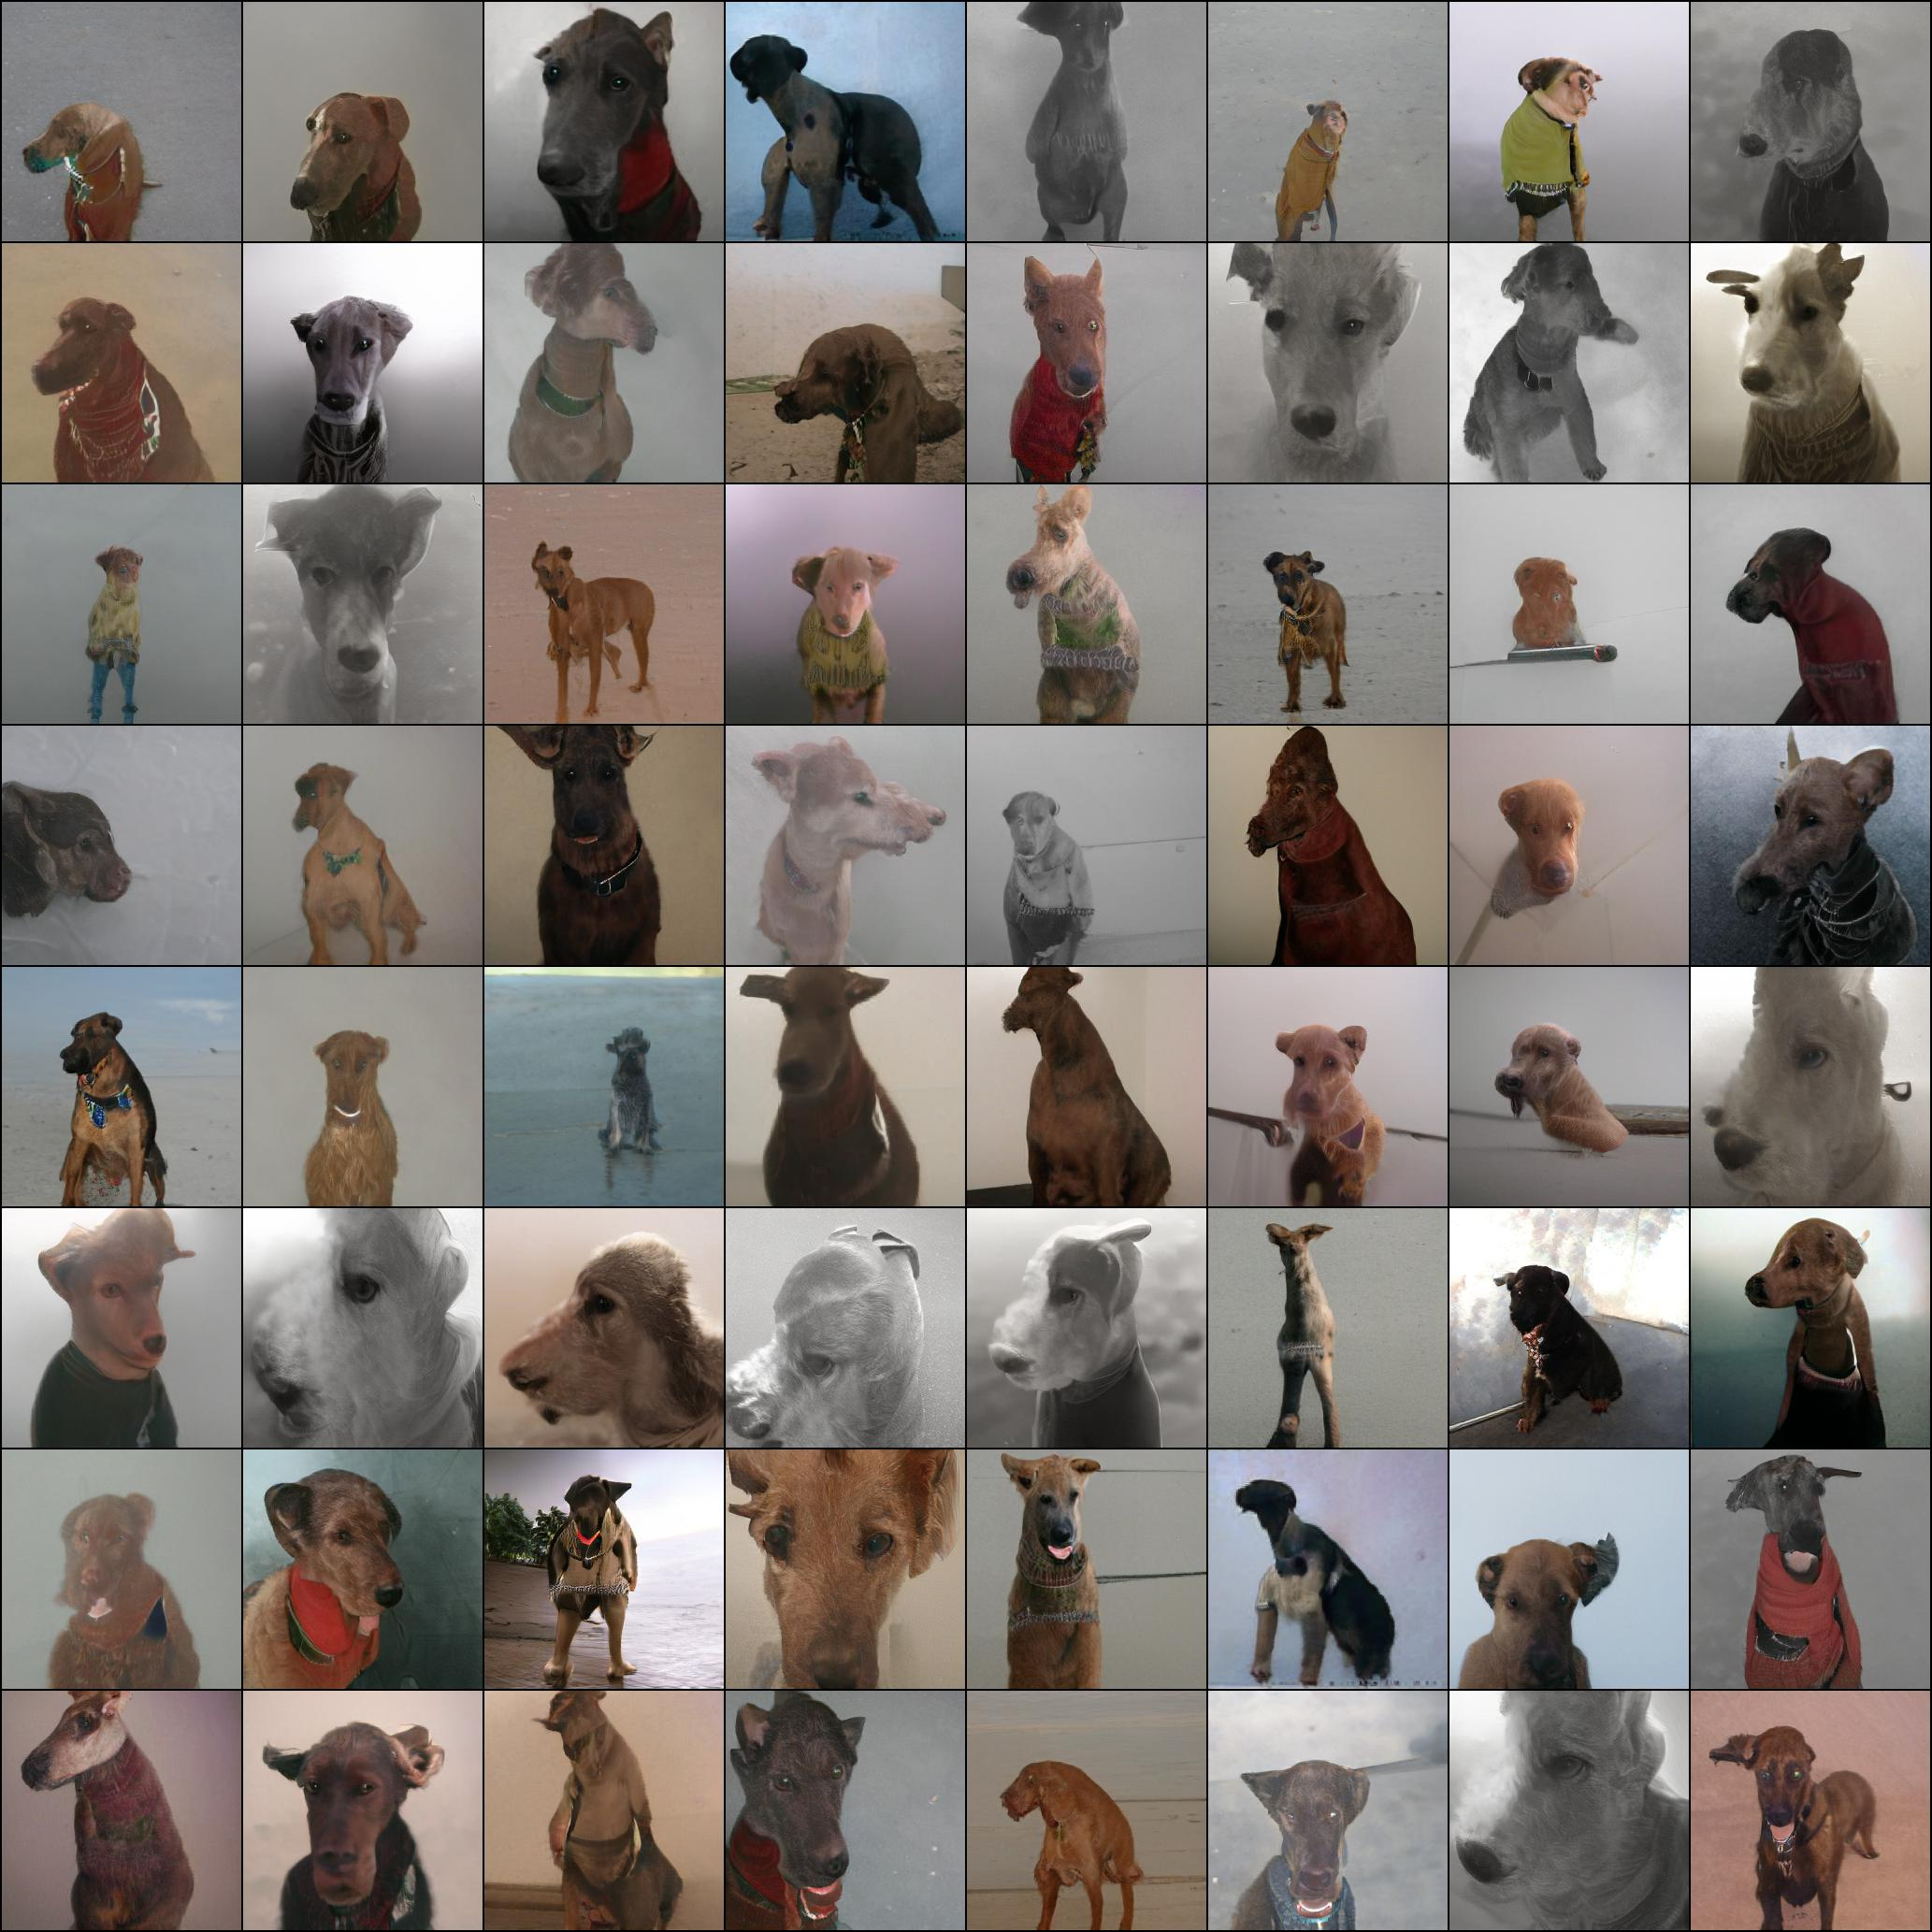

After 50 iterations...


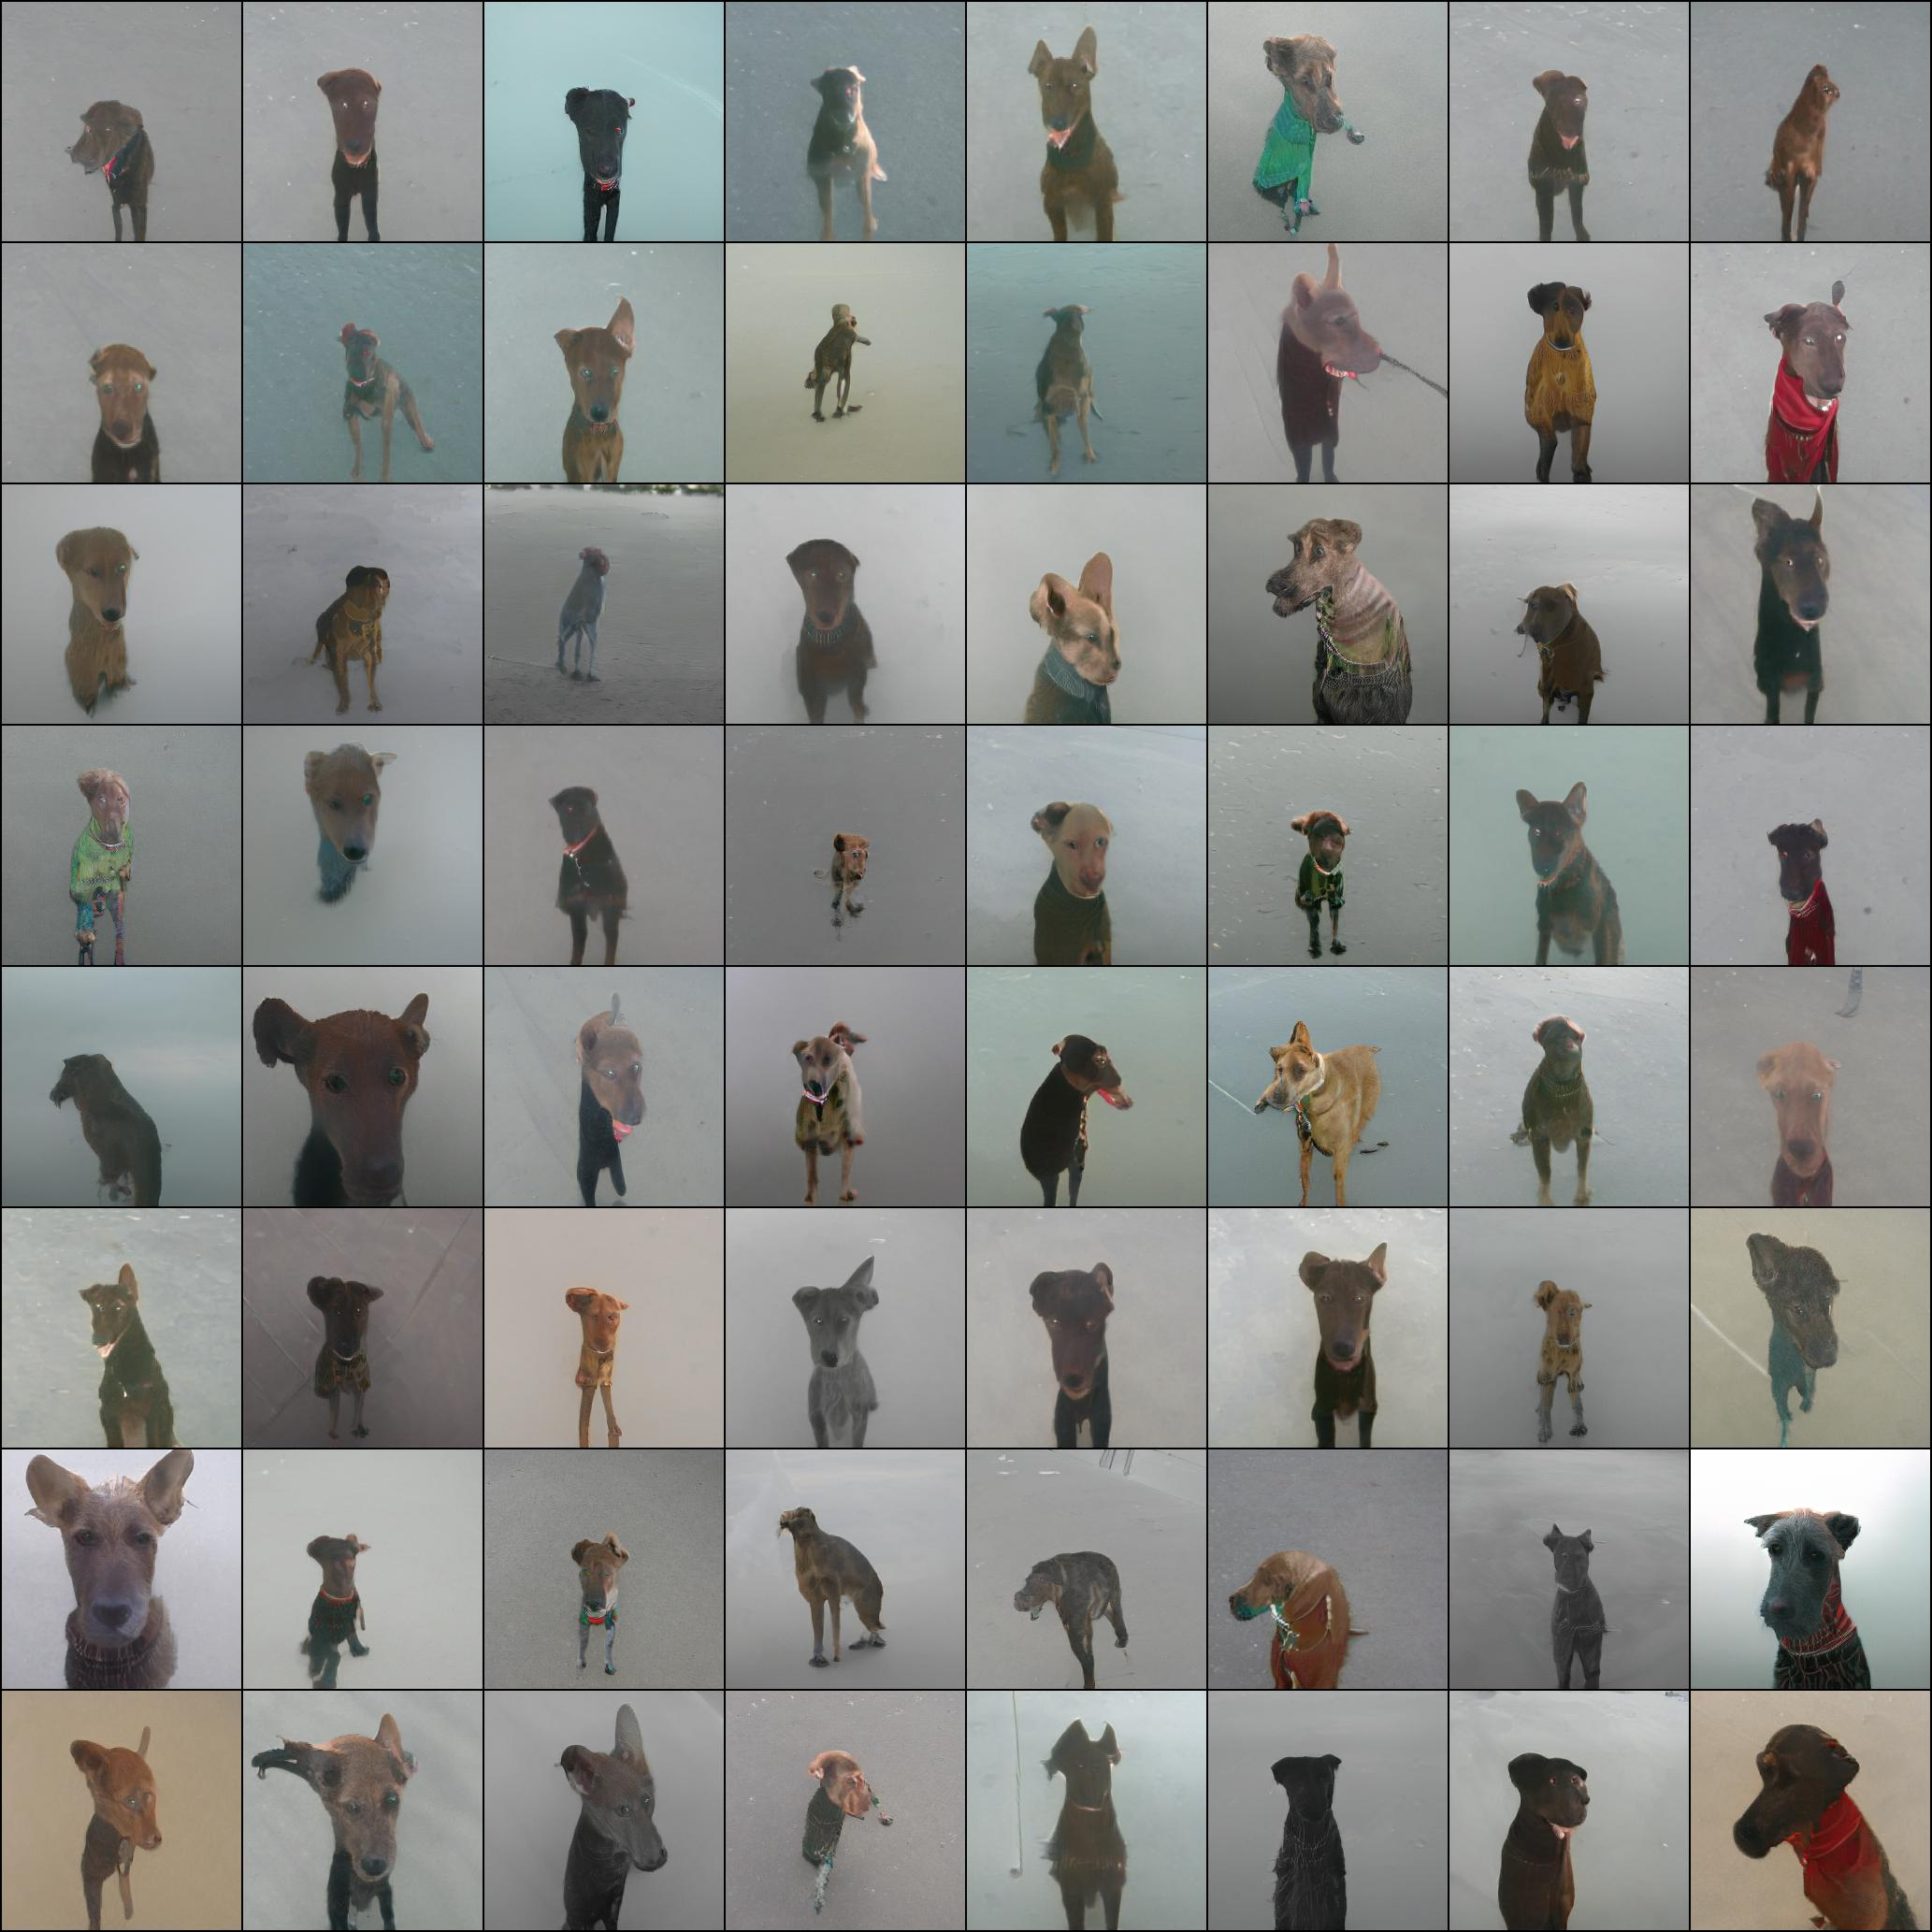

Final image for "dog in the fog" target.


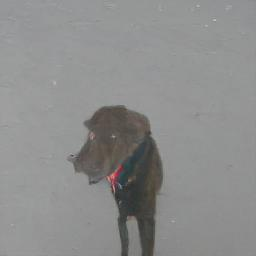

In [12]:
#@title RUN (GENERATE IMAGES)

iteration=0
generate_image(0)